---

p## Deep Learning Coding Project 3-2: Flow-Based Model

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 小明, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. To avoid unexpected issues with PyTorch 2.x, we recommend using PyTorch version 1.x.

In this coding project, you will implement 4 generative models, i.e., energy-based model, flow-based model, variational auto-encoder, and generative adverserial network, to generate MNIST images.

**We will implement a flow model, specifically a simplified [Real NVP](https://arxiv.org/abs/1605.08803), in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Unless otherwise stated, do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

In this problem, you need to train a simplified Real NVP model (without squeezing layers and multi-scale architechture) on MNIST images for
image generation and inpainting. You should

1. **Complete the missing codes in `Shuffle`, `CouplingLayer` and `FlowSequential`.**

2. **Modify model structure and hyper-parameters to train a model for better inpainting.**

An example of inpainting using flow model is shown below.

If you use Colab in this coding project, please uncomment the cell below, change the `GOOGLE_DRIVE_PATH` to your project folder and run the following cell to mount your Google drive. Then, the notebook can find the required files (i.e., utils.py). If you run the notebook locally, you can skip this cell.

In [1]:
# ### uncomment this cell if you're using Google colab
# from google.colab import drive
# drive.mount('/content/drive')

# ### change GOOGLE_DRIVE_PATH to the path of your CP3 folder
# GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/DL23SP/CP3'
# %cd $GOOGLE_DRIVE_PATH

# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

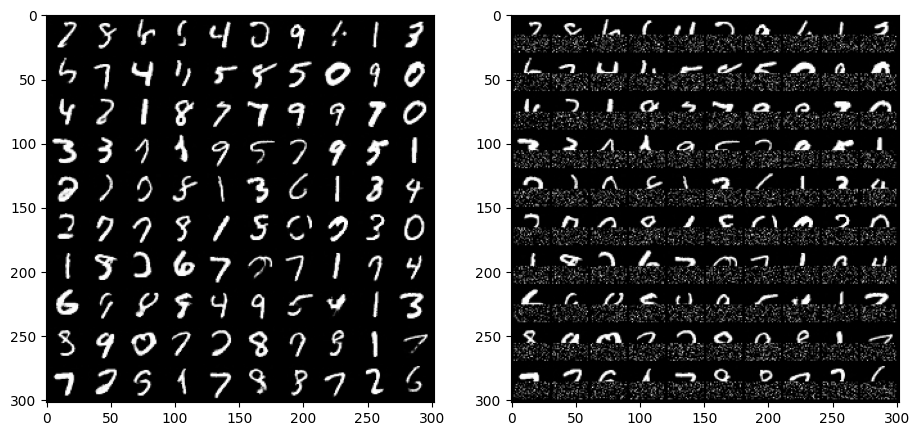

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11, 8

# read images
img_A = mpimg.imread('./flow/recovered.png')
img_B = mpimg.imread('./flow/corrupted.png')

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

### Submission

You need to submit your code (this notebook), your trained model (named `./flow/flow_best.pth`), and your report:

+ **Code**

Remember to run all the cells before submission. Keep your tuned hyperparameters unchanged.

+ **Model**

In this notebook, we select the best model based on validation loss. You can also select the best model based on the MSE of inpainting, or manually select the best one, and save it as `./flow/flow_best.pth`. **Please do not submit any other checkpoints except for `./flow/flow_best.pth`!**

+ **Report**

Please include the inpainting results (i.e., inpainted images in a $10\times 10$ array as above), the inpainting MSE on validataion set, and other relevant statistics (e.g. standard deviation) in your
report. Note that you only need to write a single report for this coding project.

### Grading

We will grade your model based on your performance of inpainting.

### Tips

+ Read [Density estimation using Real NVP](https://arxiv.org/abs/1605.08803) and [NICE: Non-linear Independent Components Estimation](https://arxiv.org/abs/1410.8516) for more useful tricks.

## Set Up Code

If you use Colab in this coding project, please make sure to mount your drive before running the cells below.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from utils import hello
hello()

Good luck!


Please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [5]:
from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from utils import save_model, load_model, corruption, train_set, val_set

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

C:\Users\Tommy\AppData\Local\Temp\ipykernel_18800\3226180785.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Model

We follow the network architecture of Real NVP. In this section, **you are NOT supposed to change any parts except the missing codes.**

In [6]:
class BatchNormFlow(nn.Module):
    """ An implementation of a batch normalization layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, momentum=0.0, eps=1e-5):
        super(BatchNormFlow, self).__init__()

        self.log_gamma = nn.Parameter(torch.zeros(num_inputs))
        self.beta = nn.Parameter(torch.zeros(num_inputs))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_inputs))
        self.register_buffer('running_var', torch.ones(num_inputs))

    def forward(self, inputs, mode='direct', **kwargs):
        if mode == 'direct':
            if self.training:
                self.batch_mean = inputs.mean(0)
                self.batch_var = (
                    inputs - self.batch_mean).pow(2).mean(0) + self.eps

                self.running_mean.mul_(self.momentum)
                self.running_var.mul_(self.momentum)

                self.running_mean.add_(self.batch_mean.data *
                                       (1 - self.momentum))
                self.running_var.add_(self.batch_var.data *
                                      (1 - self.momentum))

                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - mean) / var.sqrt()
            y = torch.exp(self.log_gamma) * x_hat + self.beta
            return y, (self.log_gamma - 0.5 * torch.log(var)).sum(-1, keepdim=True)
        else:
            if self.training:
                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - self.beta) / torch.exp(self.log_gamma)

            y = x_hat * var.sqrt() + mean

            return y, (- self.log_gamma + 0.5 * torch.log(var)).sum(-1, keepdim=True)

In [7]:
class Shuffle(nn.Module):
    """ An implementation of a shuffling layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs):
        super(Shuffle, self).__init__()
        self.perm = np.random.permutation(num_inputs)
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, mode='direct'):
        n = self.perm.shape[0]
        batch_size = inputs.size(0)
        if mode == 'direct':
            # return z = f(x) and logdet, z has the same shape with x, logdet has the shape (batch size, 1)
            z = inputs[:, self.perm]
            logdet = torch.zeros(batch_size, 1).to(inputs.device)
            return z, logdet
        else:
            # return x = f^-1(z) and logdet, x has the same shape with z, logdet has the shape (batch size, 1)
            z = inputs[:, self.inv_perm]
            logdet = torch.zeros(batch_size, 1).to(inputs.device)
            return z, logdet

In [8]:
class CouplingLayer(nn.Module):
    """ An implementation of a coupling layer
    from RealNVP (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self,
                 num_inputs,
                 num_hidden,
                 mask,
                 s_act=nn.Tanh(),
                 t_act=nn.LeakyReLU()):
        super(CouplingLayer, self).__init__()

        self.num_inputs = num_inputs
        self.mask = mask

        # define your scale_net and translate_net
        self.scale_net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.LayerNorm(num_hidden),
            t_act,
            nn.Linear(num_hidden, num_hidden),
            nn.LayerNorm(num_hidden),
            t_act,
            nn.Linear(num_hidden, num_inputs),
            s_act
        )

        self.translate_net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.LayerNorm(num_hidden),
            t_act,
            nn.Linear(num_hidden, num_hidden),
            nn.LayerNorm(num_hidden),
            t_act,
            nn.Linear(num_hidden, num_inputs)
        )


    def forward(self, x, mode='direct'):
        mask = self.mask

        masked_inputs = x * mask
        log_s = self.scale_net(masked_inputs)*(1-mask)
        s = torch.exp(log_s)
        t = self.translate_net(masked_inputs)

        if mode == 'direct':
            # complete code here;  x - > z
            # return z = f(x) and logdet, z has the same shape with x, logdet has the shape (batch size, 1)
            z = masked_inputs + (1 - mask) * (x * s + t)
            logdet = torch.sum(log_s, dim=1, keepdim=True)
            return z, logdet
        else:
            # complete code here; z - > x
            # return x = f^-1(z) and logdet, x has the same shape with z, logdet has the shape (batch size, 1)
            x_recovered = masked_inputs + (1 - mask) * ((x - t) / s)
            logdet = -torch.sum(log_s, dim=1, keepdim=True)
            return x_recovered, logdet

In [9]:
class FlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def __init__(self, device, *args):
        super().__init__(*args)
        self.prior = torch.distributions.Normal(
            torch.tensor([0.0]).to(device),
            torch.tensor([1.0]).to(device)
        )

    def _pre_process(self, x):
        """
        Args:
            x (torch.Tensor): Input image.
        Returns:
            y (torch.Tensor): logits of `x`.
        See Also:
            - Modeling logits: https://arxiv.org/abs/1605.08803, Section 4.1
        """
        return x.log() - (1. - x).log()

    def forward(self, inputs, mode='direct', logdets=None, **kwargs):
        """ Performs a forward or backward pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        self.num_inputs = inputs.size(-1)

        if logdets is None:
            logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['direct', 'inverse']
        if mode == 'direct':
            if kwargs.get("pre_process", True):
                inputs = self._pre_process(inputs)
            for module in self._modules.values():
                inputs, logdet = module(inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, mode, **kwargs)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs, pre_process=True):
        u, log_jacob = self(inputs, pre_process=pre_process)
        # return the log probability with shape (batch size, 1)
        # Compute log probability of `u` under the prior Gaussian distribution
        log_p_u = self.prior.log_prob(u).sum(dim=1, keepdim=True)
        
        # Total log probability: p(x) = p(u) + log |det J|
        log_prob_x = log_p_u + log_jacob

        return log_prob_x

    @torch.no_grad()
    def sample_images(self, n_samples=100, save=True, save_dir='./flow'):
        self.eval()
        samples, _ = self.forward(self.prior.sample([n_samples, 28 * 28]).squeeze(-1), mode='inverse')
        imgs = torch.sigmoid(samples).view(n_samples, 1, 28, 28)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs

## Inpainting

We have implemented an example inpainting function.

**You can modify the number of sampling steps in this function.**

Hint: We set the number of sampling steps as 1000 by default, you can decrease the number of sampling steps for faster evaluation. Note that a small number of sampling steps may hurt the quality of generated samples and lead to bad evaluation result.

In [10]:
def inpainting(model, inputs, mask, device, save=True, save_dir='./flow/inpainting'):
    num_samples = inputs.shape[0]
#     torchvision.utils.save_image(inputs[:100], os.path.join(save_dir, 'corrupted.png'), nrow=10)
    inputs = inputs.view(num_samples, -1).to(device)
    mask = mask.view(num_samples, -1).to(device)
    inputs = inputs.log() - (1. - inputs).log()

    ep = torch.randn(inputs.size()).to(device)
    os.makedirs(os.path.join(save_dir, 'recover_process'), exist_ok=True)
    for i in range(1000):

        alpha = 0.2
        inputs.requires_grad_()
        log_probs = model.log_probs(inputs, pre_process=False)
        dx = torch.autograd.grad([log_probs.sum()], [inputs])[0]
        dx = torch.clip(dx, -10, 10)

        with torch.no_grad():
            inputs = inputs * mask + (1 - mask) * (inputs + alpha * dx).clip(-10, 10)

        imgs = torch.sigmoid(inputs.view(num_samples, 1, 28, 28))

        if i % 10 == 0 and save:
            torchvision.utils.save_image(imgs[:100], os.path.join(
                save_dir, 'recover_process/recovered_iter{:03d}.png'.format(i + 1)), nrow=10)
    if save:
        torchvision.utils.save_image(imgs[:100], os.path.join(
        save_dir, 'recovered.png'.format(i + 1)), nrow=10)
    return imgs

## Evaluation and Training

We have implemented evaluation and training function for you. You should not modify `evaluate`. In `train`, you can modify the training code as long as you correctly save the best model in `'./flow/flow_best.pth'`.

In [11]:
def evaluate(epoch, flow_model, loader, device):
    flow_model.eval()
    val_loss = c_mse = r_mse = 0
    n_batches = 0

    pbar = tqdm(total=len(loader.dataset))
    pbar.set_description('Eval')
    for batch_idx, (data, _) in enumerate(loader):
        bs = data.shape[0]
        n_batches += data.shape[0]
        data = data.to(device)

        # compute validation loss
        with torch.no_grad():
            # sum up batch loss
            val_loss += -flow_model.log_probs(data.reshape(bs, -1)).sum().item()

        # inpainting
        imgs = data
        c_imgs, mask = corruption(imgs, type_='flow')
        r_imgs = inpainting(flow_model, c_imgs, mask, device,
                   save=(batch_idx == 0), save_dir=f"./flow/{epoch + 1}/")
        r_mse += ((imgs.view(bs, -1) - r_imgs.view(bs, -1))**2).sum().item()
        c_mse += ((imgs.view(bs, -1) - c_imgs.view(bs, -1))**2).sum().item()

        pbar.update(data.size(0))
        pbar.set_description('Val, Log likelihood in nats: {:.6f}, Corruption MSE: {:.6f}, Recovered MSE: {:.6f}'.format(
            -val_loss / n_batches, c_mse / n_batches, r_mse / n_batches))

    pbar.close()
    return val_loss / n_batches, c_mse / n_batches, r_mse / n_batches

In [12]:
def train(n_epochs, flow_model, train_loader, val_loader, optimizer, device=torch.device('cuda'), save_interval=1):
    flow_model.to(device)
    best_val_loss = np.inf

    for epoch in range(n_epochs):
        train_loss = 0
        n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        for i, (x, _) in enumerate(train_loader):
            # compute loss
            n_batches += x.shape[0]
            flow_model.train()
            x = x.to(device)
            loss = -flow_model.log_probs(x.reshape(x.shape[0], -1))
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            train_loss += loss.sum().item()

            pbar.update(x.size(0))
            pbar.set_description('Train Epoch {}, Log likelihood in nats: {:.6f}'.format(epoch + 1,
                                                                                         -train_loss / n_batches))
        pbar.close()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./flow/{epoch + 1}', exist_ok=True)
            flow_model.eval()
            save_model(f'./flow/{epoch + 1}/flow.pth', flow_model, optimizer)

            val_loss, c_mse, r_mse = evaluate(epoch, flow_model, val_loader, device)

            # sample and save images
            flow_model.sample_images(
                save=True, save_dir=f"./flow/{epoch + 1}/")

            # feel free to change the following metric to MSE for model selection!
            if val_loss < best_val_loss:
                print(
                    f'Current validation loss: {best_val_loss} -> {val_loss}')
                best_val_loss = val_loss
                save_model('./flow/flow_best.pth', flow_model)

Here we set up the model.

In [13]:
num_inputs = 28 * 28
num_hidden = 512
num_blocks = 8

modules = []
masks = []

mask = torch.arange(0, num_inputs) % 2
mask = mask.to(device).float()
masks.extend([mask, 1 - mask])
mask2 = torch.zeros_like(mask)
mask2[: num_inputs//2] = 1
masks.extend([mask2, 1 - mask2])

for i in range(num_blocks):
    modules += [
        CouplingLayer(
            num_inputs, num_hidden, masks[i % len(masks)]),
        BatchNormFlow(num_inputs, 0.1),
        Shuffle(num_inputs)
    ]

model = FlowSequential(device, *modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        # nn.init.orthogonal_(module.weight)
        nn.init.xavier_normal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

model.to(device)

FlowSequential(
  (0): CouplingLayer(
    (scale_net): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=512, out_features=784, bias=True)
      (7): Tanh()
    )
    (translate_net): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (1): BatchNormFlow()
  (2): Shuffle()
  (3): Couplin

DataLoader for validation

In [14]:

val_loader = DataLoader(val_set, batch_size=500, pin_memory=True,  shuffle=True, num_workers=1)

Now we can set up the train DataLoader, the optimizer and start training, you can modify training hyperparameters in this block. Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [15]:
# feel free to change training hyper-parameters!
train_loader = DataLoader(train_set, batch_size=128, pin_memory=True,
                          drop_last=False, shuffle=True, num_workers=8)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

train(100, model, train_loader, val_loader, optimizer, device, save_interval=10)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: inf -> 1184.38005625


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1184.38005625 -> 1162.6302125


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1162.6302125 -> 1149.06215


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1149.06215 -> 1141.72781875


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1141.72781875 -> 1134.65725


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1134.65725 -> 1130.355325


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1130.355325 -> 1129.9976625


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1129.9976625 -> 1126.5976


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Current validation loss: 1126.5976 -> 1126.15425625


## Evaluation

Make sure your code runs fine with the following cell. 

In [16]:
model.load_state_dict(load_model('./flow/flow_best.pth')[0])
val_loss, c_mse, r_mse = evaluate(int(1e4), model, val_loader, device)
print("[Evaluation] val_loss: {}, c_mse: {}, r_mse: {}".format(val_loss, c_mse, r_mse), flush=True)

d:\课程\大二下\深度学习\CodingProject3\utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


  0%|          | 0/10000 [00:00<?, ?it/s]

[Evaluation] val_loss: 1126.470225, c_mse: 51.8848912109375, r_mse: 28.669938671875
